### Solve IK using UR5e on Husky

In [1]:
import copy,cv2,glob,os,mujoco
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mujoco_parser import MuJoCoParserClass
from util import r2quat,rpy2r,r2rpy,create_folder_if_not_exists
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_husky_ur5e_rg2_d435.xml`

In [2]:
xml_path = '../asset/husky_ur5e/scene_husky_ur5e_rg2_d435.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=True)

dt:[0.0020] HZ:[500]
n_dof (=nv):[22]
n_geom:[59]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[24]
body_names:['world', 'base_husky', 'front_left_wheel_link', 'front_right_wheel_link', 'rear_left_wheel_link', 'rear_right_wheel_link', 'base_ur5e', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'd435i', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link']
n_joint:[17

### Loop

In [3]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/husky_ur5e_ik_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[45] images removed.


In [4]:
# Configuration
PLOT_EVERY = 20
SAVE_VID   = True
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[20] SAVE_VID:[1]


Pressed ESC
Quitting.


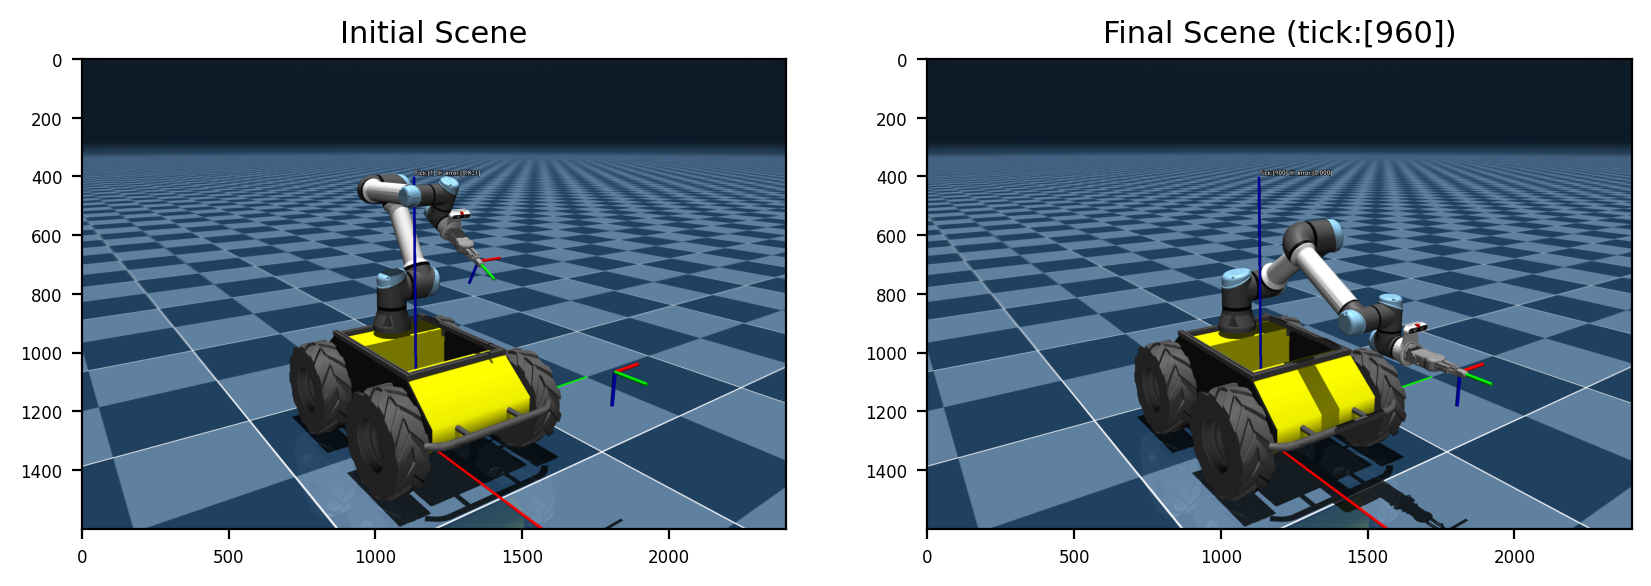

In [5]:
env.init_viewer(viewer_title='UR5e on Husky',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=145,distance=2.0,elevation=-15,lookat=[0.11,0.01,0.6])
env.reset()

# Indices for control
rev_joint_names_ur5 = [
    'shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
    'wrist_1_joint','wrist_2_joint','wrist_3_joint']
idxs_ur5_fwd  = [env.model.joint(jname).qposadr[0] for jname in rev_joint_names_ur5]
idxs_ur5_jac  = [env.model.joint(jname).dofadr[0] for jname in rev_joint_names_ur5]
idxs_ur5_step = [env.ctrl_joint_names.index(jname) for jname in rev_joint_names_ur5]

# UR initial position
q_ur_init = np.radians([0,-120,120,30,90,0])
env.forward(q=q_ur_init,joint_idxs=idxs_ur5_fwd)

# Get current and target positions
p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
p_trgt,R_trgt = p_tcp+np.array([0.6,0,-0.2]),rpy2r(np.radians([0,-30,0]))@R_tcp

# Loop
q = env.get_qpos_joints(joint_names=rev_joint_names_ur5)
tick = 0
while env.is_viewer_alive():
    # Increase tick
    tick += 1
    
    # Solve inverse kinematics
    J,ik_err = env.get_ik_ingredients(
        body_name='tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True)
    dq = env.damped_ls(J,ik_err,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[idxs_ur5_jac]
    env.forward(q=q,joint_idxs=idxs_ur5_fwd) # forward kinematics
    # env.step(ctrl=q,ctrl_idxs=idxs_ur5_step) # forward dynamics
    ik_err_norm = np.linalg.norm(ik_err)
    
    # Render
    if (tick%PLOT_EVERY)==0 or (tick)==1:
        # env.update_viewer(lookat=env.get_p_body('base_husky'))
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.plot_T(p=np.array([0,0,1]),R=np.eye(3,3),PLOT_AXIS=False,
                   label="Tick:[%d] IK error:[%.3f]"%(tick,ik_err_norm))
        env.plot_body_T(body_name='tcp_link',
                        PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],PRINT_CONTACT_BODY=False)
        env.render()
        if SAVE_VID:
            # Save iamges
            png_path = '../temp/husky_ur5e_ik_%05d.png'%(tick)
            create_folder_if_not_exists(png_path)
            image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            cv2.imwrite(png_path,image)
    
    # Save image
    if env.is_viewer_alive() and (tick)==1:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and (tick%100)==0:
        scene_img_final = env.grab_image()
        
# Close viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(tick),fontsize=11)
plt.show()

### Make a video

In [6]:
if SAVE_VID:
    # Show video
    png_paths = sorted(glob.glob('../temp/husky_ur5e_ik_*.png'))
    frames = []
    for png_path in png_paths:
        img_bgr = cv2.imread(png_path)
        img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    media.show_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),width=500)
    # Save video to mp4
    vid_path = '../vid/husky_ur5e_ik.mp4'
    create_folder_if_not_exists(vid_path)
    media.write_video(images=frames,fps=int(500/PLOT_EVERY),path=vid_path)
    print ("[%s] saved."%(vid_path))

[../vid/husky_ur5e_ik.mp4] saved.


In [7]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/husky_ur5e_ik_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[49] images removed.
